In [1]:
import kitti360_utils as ku
import generate_params as gp
import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [2]:
img_path = Path('data/KITTI-360/data_2d_raw/2013_05_28_drive_0010_sync/image_02/data_rgb/0000000458.png')

In [3]:
intrinsic_file = ku.CALIB_DIR / f'{img_path.parent.parent.name}.yaml'
mask_file = ku.MASK_DIR / f'{img_path.parent.parent.name}.png'
mask = cv.imread(str(mask_file))
des = ku.load_descriptor(intrinsic_file)

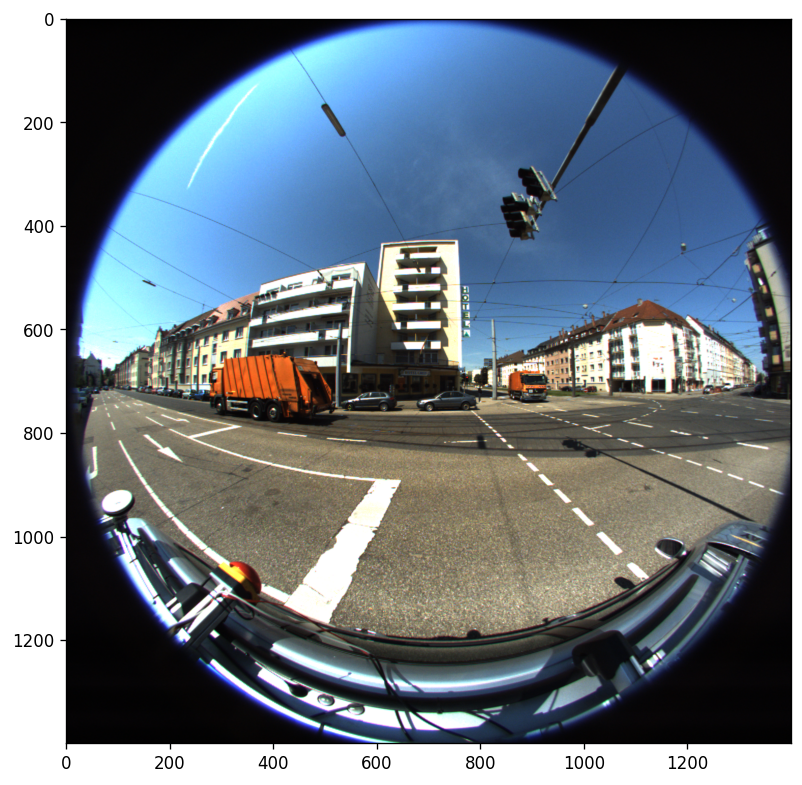

In [4]:
img = cv.imread(str(img_path))
plt.figure(figsize=(8, 8), dpi=120)
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

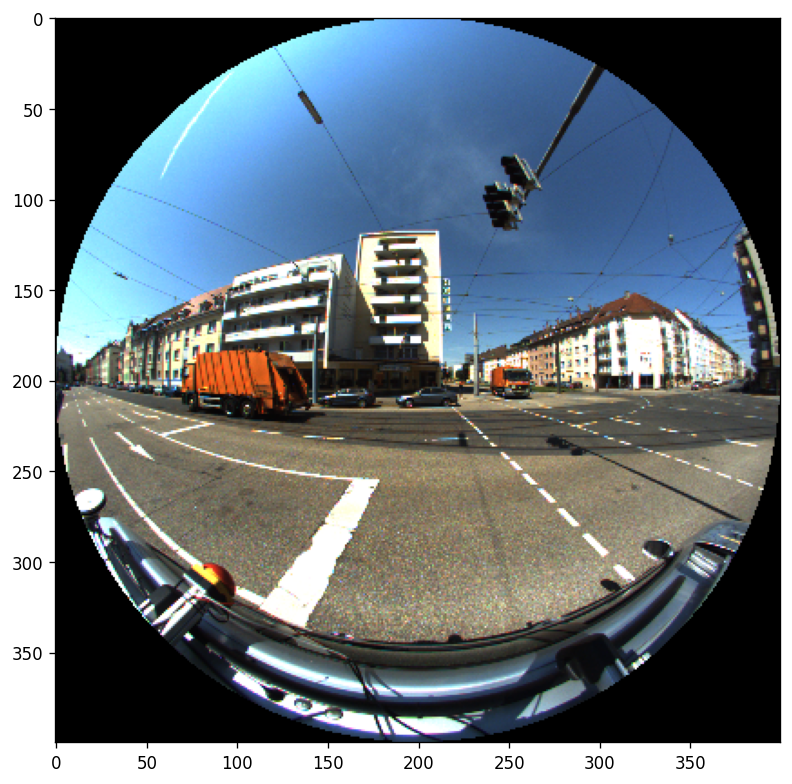

In [25]:
des_fish = ku.cam.FisheyeDS_Description(400,400, dict(afov=190, a=0.7, xi=.2))
img_fish = ku.mappings.map_img(img, [des,des_fish])[0]
plt.figure(figsize=(8, 8), dpi=120)
plt.imshow(cv.cvtColor(img_fish,cv.COLOR_BGR2RGB))

In [26]:
def get_radial_mask(size, border:int = 2) -> np.ndarray:
    rad = (min(size)) / 2 - border
    grid = np.mgrid[:size[0],:size[1]].astype(np.float32)
    grid -= np.array([(size[0]-1)/2, (size[1]-1)/2]).reshape(-1,1,1)
    r_2 = grid[0,...] ** 2 + grid[1,...] ** 2
    mask = r_2 <= rad**2
    return mask

In [27]:
def get_mask(size):
    mask = ~get_radial_mask(size, 0 )

    lat = 220j
    mid = 320j

    x, y, z = 0+lat, 199.5+mid, 399+lat
    w = z-x
    w /= y-x
    c = (x-y)*(w-abs(w)**2)/2j/w.imag-x

    xs = np.arange(0,mask.shape[1])
    ys = np.sqrt( np.abs(c+x)**2 - (xs+c.real)**2 ) - c.imag

    mask[np.mgrid[:mask.shape[0],:mask.shape[1]][0] > ys] = True

    return mask

In [28]:
mask_2 = get_mask((400,400))

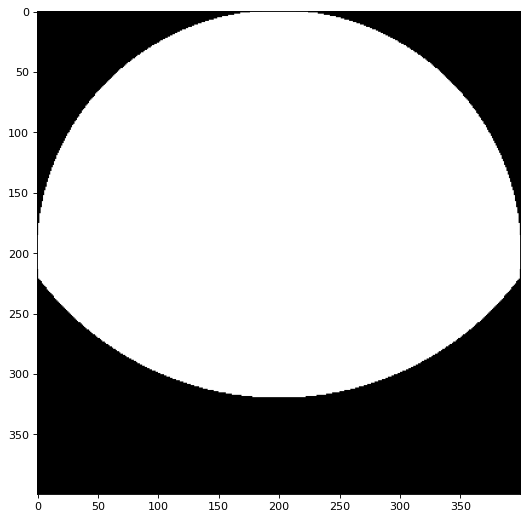

In [29]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(cv.cvtColor((~mask_2).astype(np.uint8)*255,cv.COLOR_BGR2RGB))

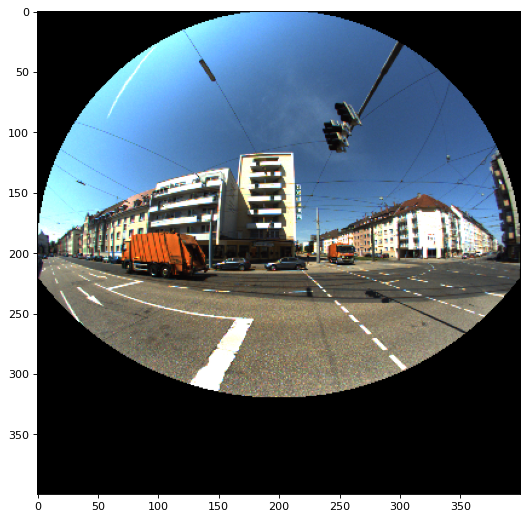

In [30]:
img_fish[mask_2] = 0
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(cv.cvtColor(img_fish,cv.COLOR_BGR2RGB))

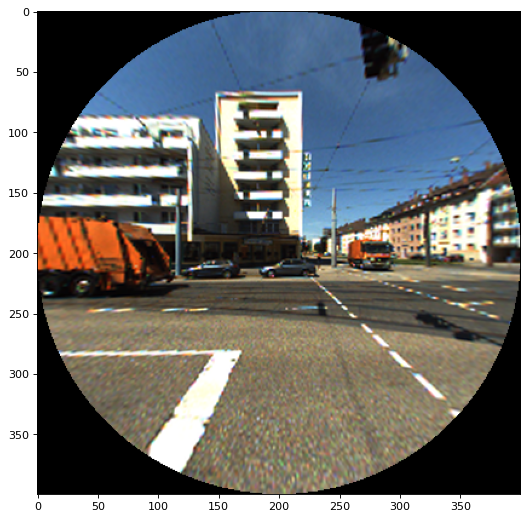

In [41]:
des_fish_2 = ku.cam.FisheyeDS_Description(400,400, dict(afov=100, a=0, xi=0))
img_fish_2 = ku.mappings.map_img(img_fish, [des_fish,des_fish_2])[0]
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(cv.cvtColor(img_fish_2,cv.COLOR_BGR2RGB))

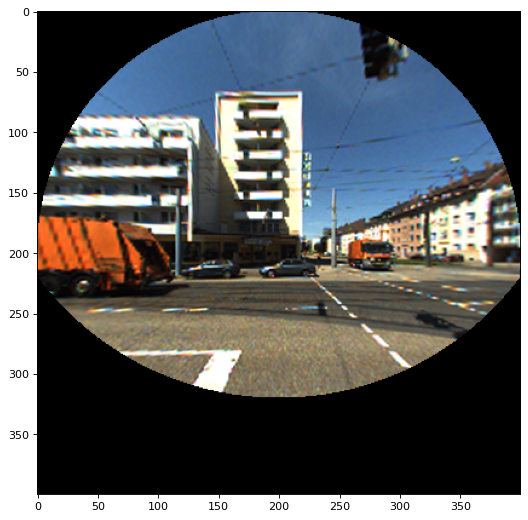

In [42]:
img_fish_2[mask_2] = 0
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(cv.cvtColor(img_fish_2,cv.COLOR_BGR2RGB))

In [ ]:
for sequence in ku.IMG_DIR.iterdir():
    for camera in sequence.iterdir():
        camera_data = camera / "data_rgb"
        for img_path in camera_data.iterdir():
            print(img_path)
            img = cv.imread(str(img_path))
            plt.figure(figsize=(8, 8), dpi=80)
            plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

            intrinsic_file = ku.CALIB_DIR / f'{camera.name}.yaml'
            mask_file = ku.MASK_DIR / f'{camera.name}.png'
            mask = cv.imread(str(mask_file))

            gen_params = ku.get_gen_params_from_mask(camera.name, gp.GEN_PARAMS_DS)
            gen_dess = ku.get_max_des_by_rot(gen_params, ku.cam.FisheyeDS_Description )

            print(intrinsic_file)
            des = ku.load_descriptor(intrinsic_file)

            rectified = ku.rectify_img(img, des, afov=130)
            plt.figure(figsize=(8, 8), dpi=80)
            plt.imshow(cv.cvtColor(rectified,cv.COLOR_BGR2RGB))

            for gen_des in gen_dess:
                gen_des.f = 200
                gen_des.xi_ = 0
                gen_des.a_ = 0
                proj_img = ku.project_and_mask(img, mask, [des, gen_des], circular_masking = False, raise_exception=False)
                plt.figure(figsize=(8, 8), dpi=80)
                plt.imshow(cv.cvtColor(proj_img,cv.COLOR_BGR2RGB))
            break